In [1]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms # for loading the data and  for prepeocessing images
from torch.utils.data import DataLoader,random_split,ConcatDataset # for Bbatch and loading the data efficiently
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, DataLoader
import numpy as np
from torch.optim.lr_scheduler import StepLR
import torchvision.models as models
from torchvision import transforms



In [2]:
from PIL import Image
import os
import shutil

data_dir = "Corn"
backup_dir = "corrupted_images"

# Create backup folder if not exists
os.makedirs(backup_dir, exist_ok=True)

bad_files = []
moved = 0

for root, _, files in os.walk(data_dir):
    for file in files:
        path = os.path.join(root, file)

        try:
            # Try to open and verify the image
            with Image.open(path) as img:
                img.verify()

            # Try loading the image fully
            with Image.open(path) as img:
                img.load()

        except Exception:
            print("Corrupted image moved:", path)
            bad_files.append(path)

            # Move to backup folder
            dest = os.path.join(backup_dir, os.path.basename(path))
            shutil.move(path, dest)
            moved += 1

print(f"\nTotal corrupted images moved: {moved}")
print(f"📁 Backup folder: {backup_dir}")



Total corrupted images moved: 0
📁 Backup folder: corrupted_images


In [3]:
from torchvision import datasets
from PIL import Image
import os

data_path = "Corn"

dataset = datasets.ImageFolder(data_path)

print("Classes:", dataset.classes)
print("Number of classes:", len(dataset.classes))
print("Total images:", len(dataset))

# Check size of first 10 images
for i in range(10):
    img_path, label = dataset.samples[i]
    img = Image.open(img_path)
    print(f"{os.path.basename(img_path)} -> size: {img.size}, mode: {img.mode}")


Classes: ['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy']
Number of classes: 4
Total images: 52359
100_brightness_adjusted.jpg -> size: (256, 256), mode: RGB
100_contrast_adjusted.jpg -> size: (256, 256), mode: RGB
100_cropped.jpg -> size: (100, 100), mode: RGB
100_flipped_horizontal.jpg -> size: (256, 256), mode: RGB
100_flipped_vertical.jpg -> size: (256, 256), mode: RGB
100_gaussian_noise.jpg -> size: (256, 256), mode: RGB
100_high_pass.jpg -> size: (256, 256), mode: RGB
100_hist_equalized.jpg -> size: (256, 256), mode: L
100_jittered.jpg -> size: (100, 100), mode: RGB
100_laplacian.jpg -> size: (256, 256), mode: RGB


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7695861..2.0776608].


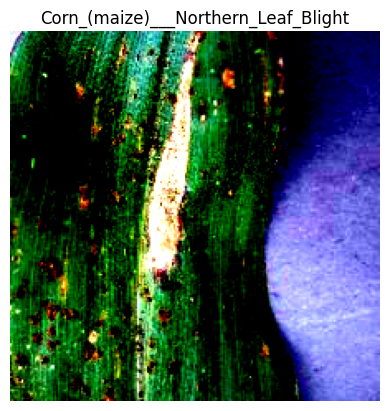

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.64].


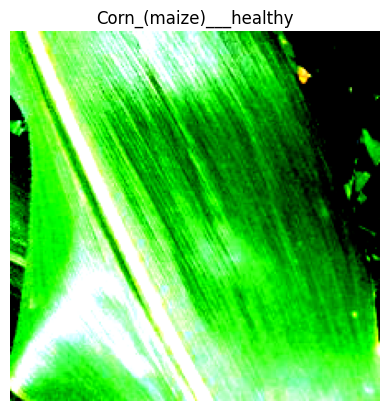

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].


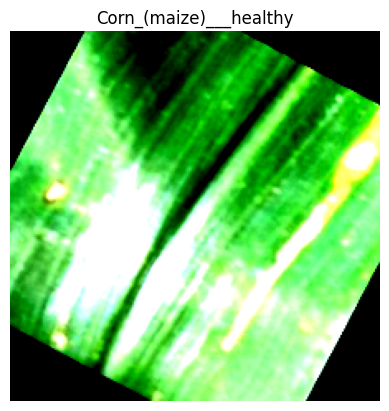

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5952941..1.9920369].


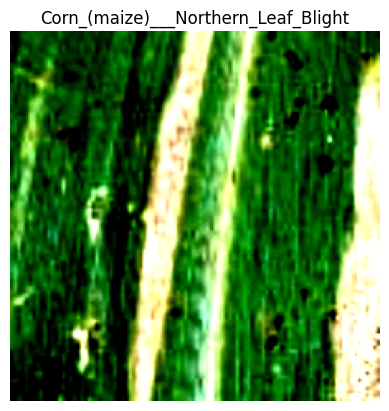

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].


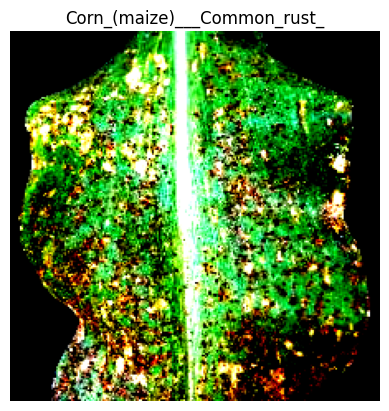

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),            # Required for ResNet50
    transforms.Lambda(lambda img: img.convert("RGB")),  # Fix L mode images
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],           # ImageNet mean
        std=[0.229, 0.224, 0.225]             # ImageNet std
    )
])

dataset = datasets.ImageFolder("Corn", transform=transform)
Loader=DataLoader(dataset,batch_size=5,shuffle=True)
images,labels=next(iter(Loader))
def imshow(img,title):
  img = img.numpy().transpose((1, 2, 0))  # Convert (C,H,W) → (H,W,C)
  plt.imshow(img)
  plt.title(title)
  plt.axis('off')
  plt.show()

# Show first 5 images
for i in range(5):
    imshow(images[i], title=dataset.classes[labels[i]])



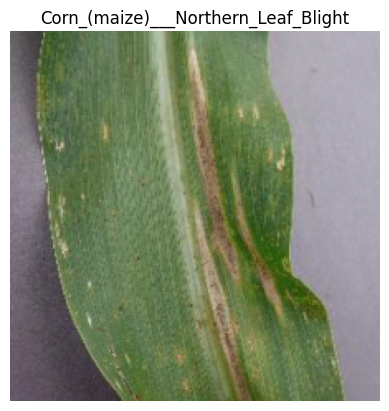

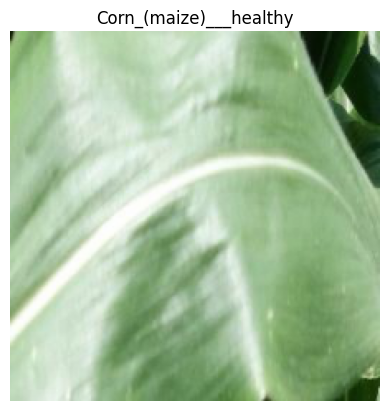

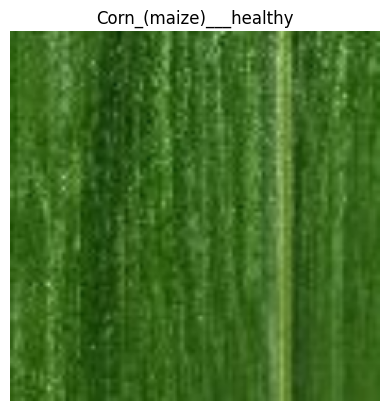

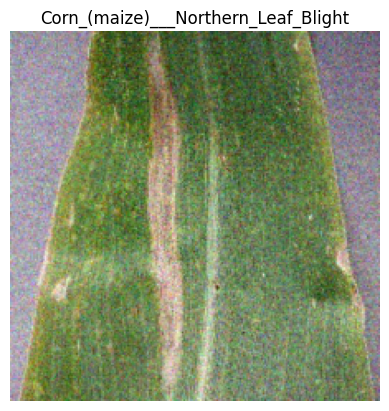

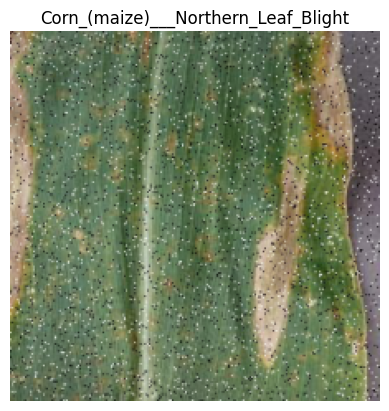

In [5]:


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

dataset = datasets.ImageFolder("Corn", transform=transform)
Loader = DataLoader(dataset, batch_size=5, shuffle=True)

images, labels = next(iter(Loader))

# ---- UNNORMALIZATION FUNCTION ----
def unnormalize(img):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img.numpy().transpose((1, 2, 0))  # C,H,W → H,W,C
    img = std * img + mean                  # undo normalization
    img = np.clip(img, 0, 1)                # ensure valid range
    return img

# ---- DISPLAY IMAGES ----
def imshow(img, title):
    img = unnormalize(img)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

# Show the first 5 images
for i in range(5):
    imshow(images[i], dataset.classes[labels[i]])


In [6]:
num_clas=len(dataset.classes)
print("Classes",(num_clas))

Classes 4


In [7]:
all_labels = []

for i in range(len(dataset)):
    _, label = dataset[i]
    all_labels.append(label)

all_labels = np.array(all_labels)
indices = np.arange(len(dataset))
# 2. First split: Train and tem
train_idx, temp_idx = train_test_split(
    indices,
    test_size=0.30,
    stratify=all_labels,
    random_state=42
)

# labels for the temp set (needed for stratification again)
temp_labels = all_labels[temp_idx]
# 3. Split Temp → Val (15%) + Test (15%)
# temp is 30%, so val and test each get 15%
val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.50,               # half of 30% = 15%
    stratify=temp_labels,
    random_state=42
)
# 4. Create PyTorch subsets
train_set = Subset(dataset, train_idx)
val_set   = Subset(dataset, val_idx)
test_set  = Subset(dataset, test_idx)
# 5. Dataloaders
train_loader = DataLoader(train_set, shuffle=True,  batch_size=32, num_workers=1)
val_loader   = DataLoader(val_set,   shuffle=False, batch_size=32, num_workers=1)
test_loader  = DataLoader(test_set,  shuffle=False, batch_size=32, num_workers=1)
# Print sizes

print("Train:", len(train_set))
print("Val:", len(val_set))
print("Test:", len(test_set))

Train: 36651
Val: 7854
Test: 7854


In [7]:
import torch
import torch.nn as nn
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet50 (pretrained)

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Stage 1: Freeze backbone
for param in model.parameters():
    param.requires_grad = False
# Replace final layer:
# FC → BatchNorm → Dropout → Linear

num_classes = len(dataset.classes)

model.fc = nn.Sequential(
    nn.BatchNorm1d(model.fc.in_features),
    nn.Dropout(0.3),
    nn.Linear(model.fc.in_features, num_classes)
)

model = model.to(device)

print("Model Ready with BN + Dropout + Frozen Backbone ✔")


Model Ready with BN + Dropout + Frozen Backbone ✔


In [8]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimizer = torch.optim.Adam(
    model.fc.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)


In [9]:
import torch
import os
import time
import math
import copy
import torch.nn as nn


# Safety checks (quick)
if 'model' not in globals():
    raise RuntimeError("model is not defined. Create the model before running this script.")
if 'train_loader' not in globals() or 'val_loader' not in globals():
    raise RuntimeError("train_loader and val_loader must be defined before running this script.")
if 'device' not in globals():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
else:
    device = device

model = model.to(device)

# Criterion (label smoothing)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# Small helpers to freeze/unfreeze

def freeze_backbone(m):
    # freeze everything except the final fc head
    for name, param in m.named_parameters():
        if "fc" in name or "fc." in name:
            param.requires_grad = True
        else:
            param.requires_grad = False

def unfreeze_last_two_blocks(m):
    # Unfreeze layer3 and layer4 (ResNet naming)
    for name, param in m.named_parameters():
        if ("layer3" in name) or ("layer4" in name) or ("fc" in name):
            param.requires_grad = True
        else:
            # leave others as-is (safe)
            pass


# EarlyStopping

class EarlyStopping:
    def __init__(self, patience=6, verbose=True):
        self.patience = int(patience)
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def step(self, score):
        # score: validation accuracy (higher is better)
        if self.best_score is None or score > self.best_score:
            self.best_score = score
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
                return True
            return False
# Core train function (stage-aware, resumable)
def run_stage(model,
              stage_name,
              freeze_mode,
              lr,
              weight_decay,
              num_epochs,
              checkpoint_dir="checkpoints",
              checkpoint_every_steps=100,
              resume=True):
    """
    freeze_mode: "backbone" -> freeze backbone, train head
                 "finetune"  -> unfreeze last 2 blocks + head
    """
    os.makedirs(checkpoint_dir, exist_ok=True)
    ckpt_path = os.path.join(checkpoint_dir, f"ckpt_{stage_name}.pth")
    best_model_path = os.path.join(checkpoint_dir, f"best_{stage_name}.pth")

    # 1) set freeze/unfreeze
    if freeze_mode == "backbone":
        freeze_backbone(model)
        print(f"[{stage_name}] Backbone frozen. Training FC head only.")
    elif freeze_mode == "finetune":
        unfreeze_last_two_blocks(model)
        print(f"[{stage_name}] Unfrozen layer3+layer4 + FC head for fine-tuning.")
    else:
        raise ValueError("freeze_mode must be 'backbone' or 'finetune'")

    # 2) create optimizer for currently trainable params
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                                 lr=lr, weight_decay=weight_decay)

    # 3) scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                           mode='min',
                                                           factor=0.5,
                                                           patience=3,
                                                           verbose=True)

    # 4) resume logic
    start_epoch = 0
    start_step = 0
    best_val_acc = 0.0
    if resume and os.path.exists(ckpt_path):
        print(f"[{stage_name}] Found checkpoint. Attempting to resume...")
        ckpt = torch.load(ckpt_path, map_location=device)
        # load model weights (safe load)
        model.load_state_dict(ckpt['model_state_dict'])
        # re-create optimizer matching current trainable params then load state
        try:
            optimizer.load_state_dict(ckpt['optimizer_state_dict'])
        except Exception as e:
            print(f"[{stage_name}] Warning: optimizer state could not be fully loaded ({e}). Re-initialized optimizer.")
        try:
            scheduler.load_state_dict(ckpt['scheduler_state_dict'])
        except Exception as e:
            print(f"[{stage_name}] Warning: scheduler state could not be loaded ({e}). Re-initialized scheduler.")
        best_val_acc = ckpt.get('best_val_acc', 0.0)
        start_epoch = ckpt.get('epoch', 0)
        start_step = ckpt.get('step', 0)
        print(f"[{stage_name}] Resumed from epoch {start_epoch}, step {start_step}, best_val_acc {best_val_acc:.2f}%")
    else:
        print(f"[{stage_name}] No checkpoint found. Starting fresh.")

    early_stopper = EarlyStopping(patience=6, verbose=True)

    # 5) training loop
    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        t0 = time.time()

        for step, (images, labels) in enumerate(train_loader):
            # skip already-done steps on resume
            if epoch == start_epoch and step < start_step:
                continue

            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            # checkpoint every N steps (save minimal metadata)
            if (step + 1) % checkpoint_every_steps == 0:
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'best_val_acc': best_val_acc,
                    'epoch': epoch,
                    'step': step
                }, ckpt_path)
                print(f"[{stage_name}] Step checkpoint saved: epoch {epoch+1} step {step+1}")

        # epoch metrics
        train_loss = running_loss / total if total > 0 else math.nan
        train_acc = 100.0 * correct / total if total > 0 else 0.0

        # validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device, non_blocking=True)
                labels = labels.to(device, non_blocking=True)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                preds = outputs.argmax(dim=1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_loss / val_total if val_total > 0 else math.nan
        val_acc = 100.0 * val_correct / val_total if val_total > 0 else 0.0

        # scheduler and early stopping use val metrics
        try:
            scheduler.step(val_loss)
        except Exception:
            # fallback: step with no args if scheduler requires it
            try:
                scheduler.step()
            except Exception:
                pass

        stopped = early_stopper.step(val_acc)

        # print epoch summary
        print(f"[{stage_name}] Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Val Acc: {val_acc:.2f}% | Time: {time.time()-t0:.1f}s")

        # save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), best_model_path)
            print(f"[{stage_name}] New best model saved (val_acc={best_val_acc:.2f}%)")

        # epoch checkpoint (minimal)
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'best_val_acc': best_val_acc,
            'epoch': epoch + 1,
            'step': 0
        }, ckpt_path)

        if stopped:
            print(f"[{stage_name}] Early stopping triggered at epoch {epoch+1}")
            break

    print(f"[{stage_name}] done. Best val acc: {best_val_acc:.2f}%\n")
    return best_val_acc

# Run Stage 3 (FC head only) 
# ensure backbone is frozen (safe)
freeze_backbone(model)

best_stage3 = run_stage(model,
                       stage_name="Stage3_FC",
                       freeze_mode="backbone",
                       lr=1e-4,
                       weight_decay=1e-4,
                       num_epochs=10,
                       checkpoint_dir="checkpoints",
                       checkpoint_every_steps=100,
                       resume=True)

# Run Stage 4 (fine-tune last 2 blocks) 
best_overall_before = best_stage3
best_stage4 = run_stage(model,
                       stage_name="Stage4_FineTune",
                       freeze_mode="finetune",
                       lr=1e-5,
                       weight_decay=1e-4,
                       num_epochs=8,
                       checkpoint_dir="checkpoints",
                       checkpoint_every_steps=100,
                       resume=True)


# Save final model (best among stages)
# prefer best Stage4 if exists, else best Stage3 final weights
final_path = "resnet50_final_maize.pth"
if os.path.exists(os.path.join("checkpoints", "best_Stage4_FineTune.pth")):
    final_src = os.path.join("checkpoints", "best_Stage4_FineTune.pth")
elif os.path.exists(os.path.join("checkpoints", "best_Stage3_FC.pth")):
    final_src = os.path.join("checkpoints", "best_Stage3_FC.pth")
else:
    final_src = None

if final_src:
    # save to working folder
    final_state = torch.load(final_src, map_location=device)
    torch.save(final_state, final_path)
    print(f"Final best model copied to {final_path}")
else:
    # fallback: save current model
    torch.save(model.state_dict(), final_path)
    print(f"No best checkpoint found — saved current model to {final_path}")

print("All done.")


[Stage3_FC] Backbone frozen. Training FC head only.
[Stage3_FC] Found checkpoint. Attempting to resume...


/home/amon/anaconda3/envs/pytorch_env/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_3988/682129642.py:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you

[Stage3_FC] Resumed from epoch 10, step 0, best_val_acc 93.74%
[Stage3_FC] done. Best val acc: 93.74%

[Stage4_FineTune] Unfrozen layer3+layer4 + FC head for fine-tuning.
[Stage4_FineTune] Found checkpoint. Attempting to resume...
[Stage4_FineTune] Resumed from epoch 7, step 199, best_val_acc 97.75%
[Stage4_FineTune] Step checkpoint saved: epoch 8 step 200
[Stage4_FineTune] Step checkpoint saved: epoch 8 step 300
[Stage4_FineTune] Step checkpoint saved: epoch 8 step 400
[Stage4_FineTune] Step checkpoint saved: epoch 8 step 500
[Stage4_FineTune] Step checkpoint saved: epoch 8 step 600
[Stage4_FineTune] Step checkpoint saved: epoch 8 step 700
[Stage4_FineTune] Step checkpoint saved: epoch 8 step 800
[Stage4_FineTune] Step checkpoint saved: epoch 8 step 900
[Stage4_FineTune] Step checkpoint saved: epoch 8 step 1000
[Stage4_FineTune] Step checkpoint saved: epoch 8 step 1100
[Stage4_FineTune] Epoch 8/8 | Train Loss: 0.4069 | Val Loss: 0.4135 | Val Acc: 97.76% | Time: 48954.1s
[Stage4_FineTu

/tmp/ipykernel_3988/682129642.py:275: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_state = torch.load(final_src, map_location=device)


Final best model copied to resnet50_final_maize.pth
All done.


OOD DETECTION

In [13]:
state = torch.load("resnet50_final_maize.pth", map_location="cpu")
print([k for k in state.keys() if k.startswith("fc.")])


/tmp/ipykernel_9133/3253488917.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load("resnet50_final_maize.pth", map_location="cpu")


['fc.0.weight', 'fc.0.bias', 'fc.0.running_mean', 'fc.0.running_var', 'fc.0.num_batches_tracked', 'fc.2.weight', 'fc.2.bias']


In [10]:

import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

NUM_CLASSES = 4

model = models.resnet50(weights=None)

model.fc = nn.Sequential(
    nn.BatchNorm1d(2048),   # fc.0
    nn.ReLU(inplace=True),  # fc.1 (no weights)
    nn.Linear(2048, NUM_CLASSES)  # fc.2
)

model = model.to(device)

state = torch.load("resnet50_final_maize.pth", map_location=device)
model.load_state_dict(state)
model.eval()


/tmp/ipykernel_9133/646500169.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load("resnet50_final_maize.pth", map_location=device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
import torch
import torch.nn.functional as F

@torch.no_grad()
def get_logits(model, images):
    return model(images)


In [12]:
@torch.no_grad()
def energy_score(logits, T=1.0):
    return -T * torch.logsumexp(logits / T, dim=1)


In [8]:
def collect_id_energies(model, dataloader, device):
    energies = []

    model.eval()
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            logits = model(images)
            e = energy_score(logits)
            energies.append(e.cpu())

    return torch.cat(energies)


In [14]:
id_energies = collect_id_energies(model, val_loader, device)

threshold = torch.quantile(id_energies, 0.95)

print("OOD threshold:", threshold.item())


OOD threshold: -1.1355206966400146


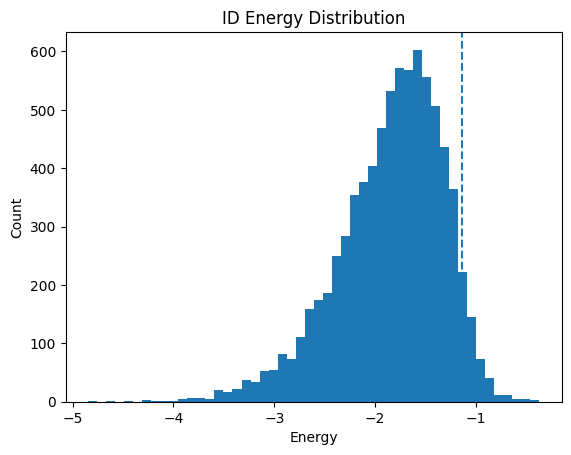

In [15]:
import matplotlib.pyplot as plt

plt.hist(id_energies.numpy(), bins=50)
plt.axvline(threshold.item(), linestyle='--')
plt.title("ID Energy Distribution")
plt.xlabel("Energy")
plt.ylabel("Count")
plt.show()


In [16]:
class TemperatureScaler(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1))

    def forward(self, logits):
        return logits / self.temperature


In [17]:
def collect_logits(model, dataloader, device):
    logits_list = []
    labels_list = []

    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)

            logits_list.append(logits)
            labels_list.append(labels)

    return torch.cat(logits_list), torch.cat(labels_list)


In [18]:
val_logits, val_labels = collect_logits(model, val_loader, device)


In [19]:
temperature_model = TemperatureScaler().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.LBFGS([temperature_model.temperature], lr=0.01, max_iter=50)


In [20]:
def optimize_temperature(logits, labels):
    def closure():
        optimizer.zero_grad()
        scaled_logits = temperature_model(logits)
        loss = criterion(scaled_logits, labels)
        loss.backward()
        return loss

    optimizer.step(closure)


In [21]:
optimize_temperature(val_logits, val_labels)


In [22]:
T = temperature_model.temperature.item()
print(f"Learned temperature: {T:.4f}")


Learned temperature: 0.5047


In [23]:
def energy_score(logits, T):
    return -T * torch.logsumexp(logits / T, dim=1)

T = 0.5047  # learned temperature

energies = []
model.eval()

with torch.no_grad():
    for images, _ in val_loader:
        images = images.to(device)
        logits = model(images)
        energies.append(energy_score(logits, T).cpu())

energies = torch.cat(energies)

ood_threshold = torch.quantile(energies, 0.95).item()
print("Final OOD threshold:", ood_threshold)


Final OOD threshold: -0.692311704158783


In [25]:
def predict_with_ood(model, x, T, threshold):
    model.eval()
    with torch.no_grad():
        logits = model(x)

        # Energy-based OOD score
        energy = -T * torch.logsumexp(logits / T, dim=1)

        if energy.item() > threshold:
            return "Unknown"
        else:
            probs = torch.softmax(logits / T, dim=1)
            return probs.argmax(dim=1).item()


In [26]:
torch.save(model.state_dict(), "model.pth")

# Save calibration
T = 0.5047
ood_threshold = -0.6923


In [27]:
def predict_id(model, x, T):
    model.eval()
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits / T, dim=1)
        return probs.argmax(dim=1).item()


In [31]:
CLASS_NAMES = [
    "Cercospora Leaf Spot (Gray Leaf Spot)",
    "Common Rust",
    "Northern Leaf Blight",
    "Healthy"
]


In [32]:
def predict_with_ood(model, x, T, threshold, class_names):
    model.eval()
    with torch.no_grad():
        logits = model(x)

        # Energy-based OOD score
        energy = -T * torch.logsumexp(logits / T, dim=1)

        if energy.item() > threshold:
            return {
                "label": "Unknown (Out-of-Distribution)",
                "confidence": None
            }

        probs = torch.softmax(logits / T, dim=1)
        conf, pred = torch.max(probs, dim=1)

        return {
            "label": class_names[pred.item()],
            "confidence": round(float(conf.item()), 4)
        }


In [29]:
def evaluate_ood(model, dataloader, T, threshold):
    model.eval()
    correct = 0
    total = 0
    ood_detected = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)
            energy = -T * torch.logsumexp(logits / T, dim=1)
            
            for i in range(len(labels)):
                if energy[i].item() > threshold:
                    # Detected as OOD
                    ood_detected += 1
                else:
                    # ID prediction
                    pred = torch.softmax(logits[i] / T, dim=0).argmax().item()
                    if pred == labels[i].item():
                        correct += 1
                total += 1

    acc = correct / total * 100
    ood_ratio = ood_detected / total * 100
    print(f"ID Accuracy: {acc:.2f}%")
    print(f"OOD Rejection Rate: {ood_ratio:.2f}%")
    return acc, ood_ratio

# Run evaluation
evaluate_ood(model, val_loader, T, ood_threshold)


ID Accuracy: 93.24%
OOD Rejection Rate: 5.00%


(93.23911382734912, 5.0038197097020625)

In [33]:
save_path = "resnet50_maize_ood.pth"

torch.save({
    'model_state_dict': model.state_dict(),
    'temperature': T,
    'ood_threshold': ood_threshold,
    'class_names': CLASS_NAMES
}, save_path)

print("✅ Full maize disease model saved")


✅ Full maize disease model saved


In [34]:
img = img.to(device).unsqueeze(0)
result = predict_with_ood(model, img, T, ood_threshold, CLASS_NAMES)
print(result)


AttributeError: to